# Problem
**Mục tiêu: Sử dụng các yếu tố sức khỏe để dự đoán một người có mắc bệnh tim hay không**

**Metric: AUC, Precision với Recall = 90 %**

Biến mục tiêu:

Có hai hướng đi:
1. Tình trạng bệnh tim với `0` là không mắc bệnh, `1` là mắc bệnh
2. Khả năng một người mắc bệnh tim (số thực mang giá trị `[0;1]`)
- **Important**: dataset của chúng ta không có sẵn biến mục tiêu dạng này, biến gần nhất là tình trạng bệnh tim nhận giá trị `0` hoặc `1`
- Đầu ra của mô hình phải phù hợp với các tính toán được y học chấp nhận

Thông qua phân tích sơ bộ, tỷ lệ mắc bệnh chung vào khoảng `8.6%`, để đầu ra thực sự có ích, thì với recall `90%` tôi mong muốn có thể có Precision tối thiểu `18%`, và với recall `95%`, precision `14%`.

Các biến dự đoán: vì đây là một vấn đề cần phân tích kỹ hơn, nên tôi sẽ thực hiện file `preprocessing.ipynb` trước khi đưa ra những nhận định về các biến dự đoán.

Tuy chúng ta không thể tự mình tìm kiếm thêm các thông tin về yếu tố sức khỏe, nhưng việc xem xét thêm các yếu tố nằm ngoài bộ dataset được chứng minh bằng các nghiên cứu y học có thể giúp ích cho việc cải tiến mô hình sau này. Vì thế, hãy xem qua một số nguồn:
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7210118/
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7871691/



In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load data

In [2]:
df_origin = pd.read_csv('data/relevant_features.csv', index_col=0)
print(df_origin.shape)
df_origin.head()

(319795, 17)


,AgeCategory,Race,GenHealth,HeartDisease,Smoking,AlcoholDrinking,Stroke,DiffWalking,Sex,Diabetic,PhysicalActivity,KidneyDisease,SkinCancer,BMI,PhysicalHealth,MentalHealth,SleepTime
0,7,5,3,0,1,0,0,0,0,3,1,0,1,16.60,3.0,30.0,5.0
1,12,5,3,0,0,0,1,0,0,0,1,0,0,20.34,0.0,0.0,7.0
2,9,5,1,0,1,0,0,0,1,3,1,0,0,26.58,20.0,30.0,8.0
3,11,5,2,0,0,0,0,0,0,0,0,0,1,24.21,0.0,0.0,6.0
4,4,5,3,0,0,0,0,1,0,0,1,0,0,23.71,28.0,0.0,8.0


# Split train test sets

In [3]:
X = df_origin.drop('HeartDisease', axis=1)
y = df_origin['HeartDisease']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
print('Train set:\n',y_train.value_counts()/y_train.size, sep='')
print('Size of train set:', y_train.size)
print('Test set:\n',y_test.value_counts()/y_test.size, sep='')
print('Size of test set:', y_test.size)

Train set:
0    0.914753
1    0.085247
Name: HeartDisease, dtype: float64
Size of train set: 223856
Test set:
0    0.913591
1    0.086409
Name: HeartDisease, dtype: float64
Size of test set: 95939


# Data preprocessing and transforming

In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [7]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

# Build, evaluate models, error analysis

## Import some important modules

In [42]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier


from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, plot_roc_curve, RocCurveDisplay

import matplotlib.pyplot as plt

## Define evaluate function

Ở đây tôi sẽ tạo ra một function thực hiện việc in ra AUC, precisions, recalls, f1 scores (sklearn's classification report) ứng với recall 90% và 95%. Ngoài ra, function sẽ hiển thị roc curve và hình ảnh trực quan xác suất bị bệnh tính toán của mô hình cho từng phần tử

In [9]:
import matplotlib.colors as mpc
import matplotlib.patches as mpatches

def find_thres(tpr: np.ndarray, fpr: np.ndarray, thres: np.ndarray, recall = 0.9):
    idx = tpr.searchsorted(recall)
    return idx, tpr[idx], fpr[idx], thres[idx]


def evaluate(model, X, y, recalls = [0.9, 0.95], name = None):
    plt.figure(figsize=(12,6))
    ax = plt.subplot(1,2,1)

    # predict probability
    prob = model.predict_proba(X)[:, 1]
    fpr, tpr, thresholds = roc_curve(y, prob)
    prob_df = pd.DataFrame({'prob': prob, 'class': y})

    # auc
    auc_score = roc_auc_score(y, prob)
    print('AUC score =', auc_score)
    roc_plot = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc = auc_score)
    roc_plot.plot(ax=ax)
    if name:
        plt.title(name)
    target_thres = {}
    precisions = {}

    # precision for each recall scores
    try:
        for recall in recalls:
            _, _, _, thres = find_thres(tpr, fpr, thresholds, recall)
            target_thres[recall] = thres
            print('Recall =', recall)
            # print(classification_report(y, prob > thres))
            conf_matrix = confusion_matrix(y, prob > thres)
            precisions[recall] = conf_matrix[-1,-1]/np.sum(conf_matrix[:,-1])
            print('Precision =',precisions[recall])
    except TypeError as e:
        print(e)
    
    # Visualize
    prob_df.sort_values('prob', inplace=True, ignore_index=True)
    plt.subplot(1,2,2)
    sc = plt.scatter(x=prob_df.index, y=prob_df['prob'].values, c=prob_df['class'].values)
    hd_color = mpc.to_hex(sc.to_rgba(1))
    no_hd_color = mpc.to_hex(sc.to_rgba(0))
    hd_patch = mpatches.Patch(color=hd_color, label='Heart disease')
    no_hd_patch = mpatches.Patch(color=no_hd_color, label='Without heart disease')
    plt.ylabel('Probability')
    plt.legend(handles = [hd_patch, no_hd_patch])
    return auc_score, target_thres, precisions

## Metrics

In [10]:
auc_scores = {}
precisions = {}

## Models

In [11]:
models = {}

### Logistic Regression

In [47]:
model = LogisticRegression(class_weight='balanced', C=0.5)
model.fit(X_train, y_train)
models['LR'] = model

/home/dnj/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.5, class_weight='balanced')

AUC score = 0.8410959010149368
Recall = 0.9
Precision = 0.1725700619982114
Recall = 0.95
Precision = 0.1426300964609986


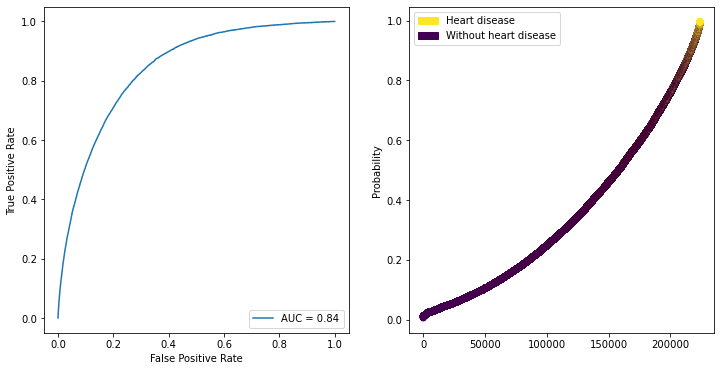

In [49]:
auc_score, target_thres, precision = evaluate(models['LR'], X_train, y_train)

AUC score = 0.8359152330105575
Recall = 0.9
Precision = 0.17035852934459922
Recall = 0.95
Precision = 0.14162904879233135


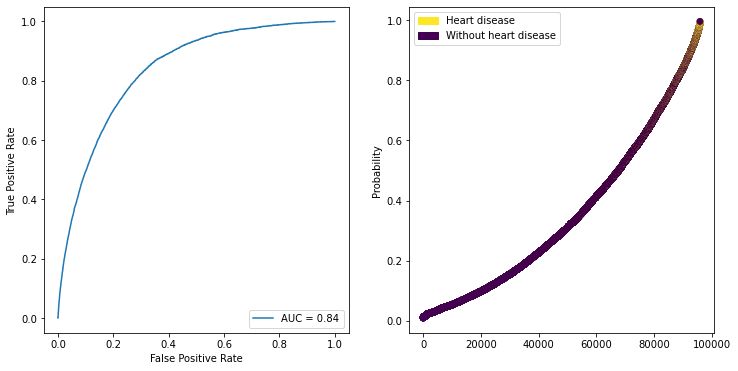

In [50]:
auc_score, target_thres, precision = evaluate(models['LR'], X_test, y_test)
auc_scores['LR'] = auc_score
precisions['LR'] = precision

### SVM

In [44]:
# model = SVC(class_weight='balanced', probability=True)
# model.fit(X_test, y_test)

In [ ]:
# auc_score, target_thres, precision = evaluate(model, X_train, y_train)

In [ ]:
# auc_score, target_thres, precision = evaluate(model, X_test, y_test)
# models['svm'] = model
# auc_scores['svm'] = auc_score
# precisions['svm'] = precision

### SGD

In [52]:
model = SGDClassifier(loss='log')
model.fit(X_train, y_train)
models['SGD'] = model

AUC score = 0.8405374632114588
Recall = 0.9
Precision = 0.17136984114313084
Recall = 0.95
Precision = 0.1413092621174563


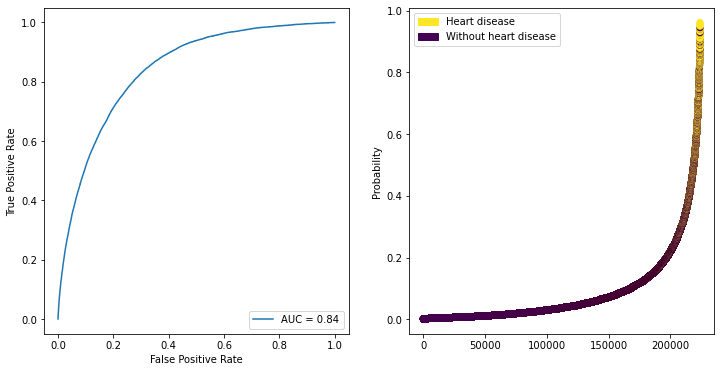

In [53]:
auc_score, target_thres, precision = evaluate(models['SGD'], X_train, y_train)

AUC score = 0.8351195670647127
Recall = 0.9
Precision = 0.16985428051001822
Recall = 0.95
Precision = 0.13995770167238344


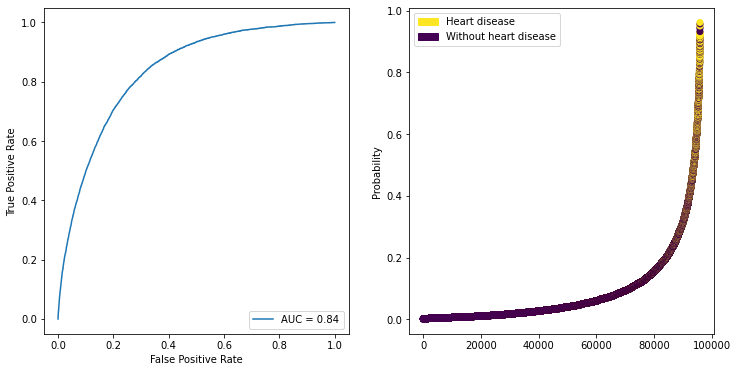

In [54]:
auc_score, target_thres, precision = evaluate(models['SGD'], X_test, y_test)
auc_scores['SGD'] = auc_score
precisions['SGD'] = precision

### Tree

In [55]:
model = DecisionTreeClassifier(class_weight='balanced', min_samples_leaf=600)
model.fit(X_train, y_train)
models['tree'] = model

AUC score = 0.83951759534146
Recall = 0.9
Precision = 0.17291240515512743
Recall = 0.95
Precision = 0.14545191867791413


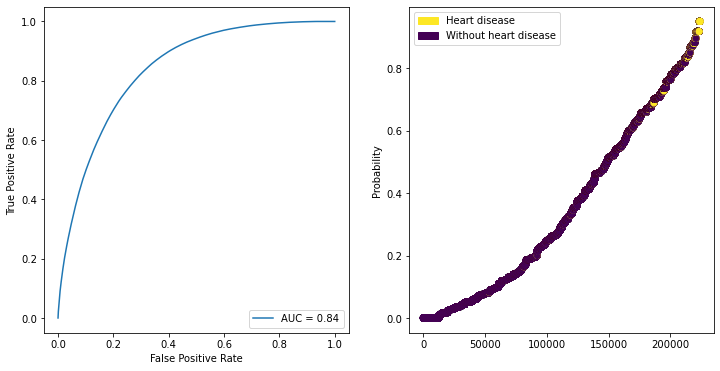

In [56]:
auc_score, target_thres, precision = evaluate(models['tree'], X_train, y_train)

AUC score = 0.8264287140969296
Recall = 0.9
Precision = 0.16804072622426455
Recall = 0.95
Precision = 0.13851678431234488


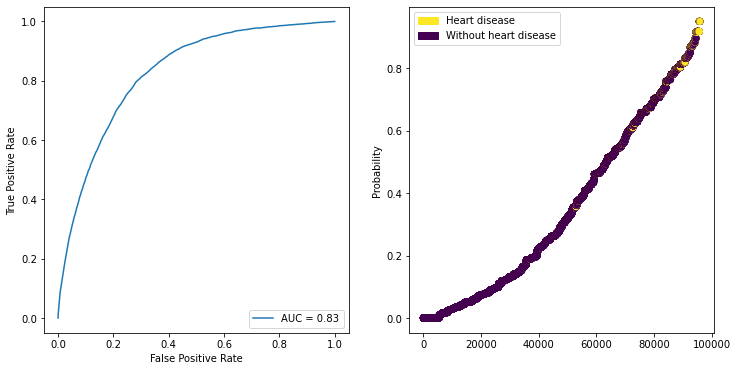

In [57]:
auc_score, target_thres, precision = evaluate(models['tree'], X_test, y_test)
auc_scores['tree'] = auc_score
precisions['tree'] = precision

### Gaussian

### Random forest

In [32]:
model = RandomForestClassifier(min_samples_leaf=200)
model.fit(X_train, y_train)
models['forest'] = model

RandomForestClassifier(min_samples_leaf=200)

AUC score = 0.8498763834911007
Recall = 0.9
Precision = 0.17772212678767307
Recall = 0.95
Precision = 0.1492065582406005


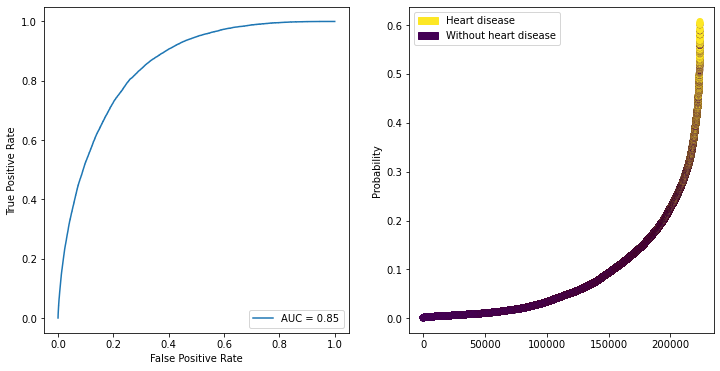

In [58]:
auc_score, target_thres, precision = evaluate(models['forest'], X_train, y_train)

AUC score = 0.8376565215069025
Recall = 0.9
Precision = 0.17314610653359638
Recall = 0.95
Precision = 0.1412885515905054


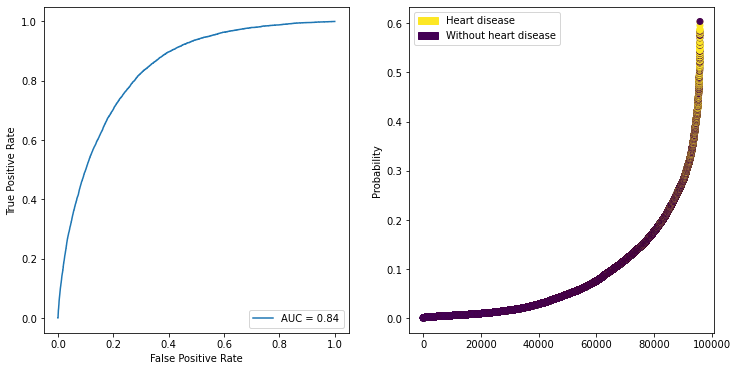

In [59]:
auc_score, target_thres, precision = evaluate(models['forest'], X_test, y_test)
auc_scores['forest'] = auc_score
precisions['forest'] = precision

### Naive Bayes

In [61]:
model = GaussianNB()
model.fit(X_train, y_train)
models['NB'] = model

AUC score = 0.8088647269726097
Recall = 0.9
Precision = 0.15678577297376253
Recall = 0.95
Precision = 0.13202723862932886


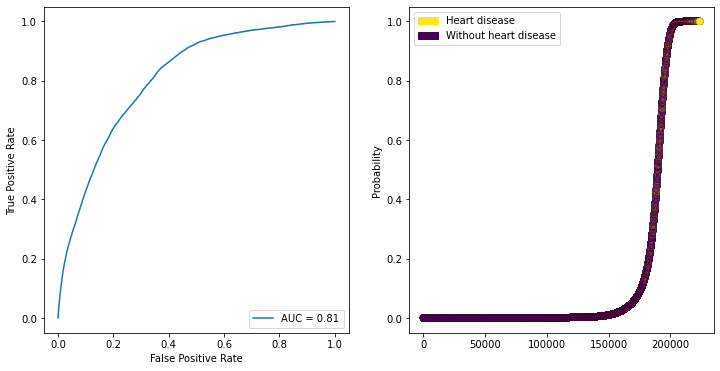

In [62]:
auc_score, target_thres, precision = evaluate(models['NB'], X_train, y_train)

AUC score = 0.804077457843594
Recall = 0.9
Precision = 0.156808340690293
Recall = 0.95
Precision = 0.1296851327317041


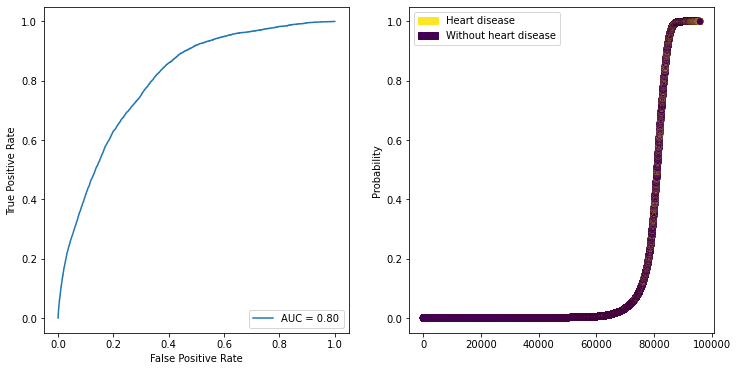

In [63]:
auc_score, target_thres, precision = evaluate(models['NB'], X_test, y_test)
auc_scores['NB'] = auc_score
precisions['NB'] = precision

### AdaBoost

In [39]:
model = AdaBoostClassifier()
model.fit(X_train, y_train)
models['Ada'] = model

AdaBoostClassifier()

AUC score = 0.8525556453641845
Recall = 0.9
Precision = 0.17817940364783266
Recall = 0.95
Precision = 0.14854998238181474


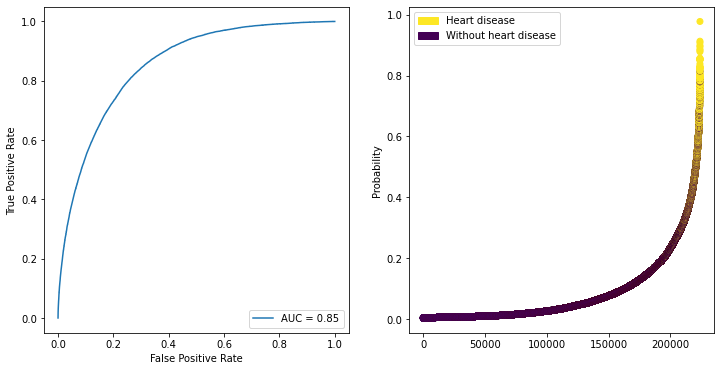

In [64]:
auc_score, target_thres, precision = evaluate(models['Ada'], X_train, y_train)

AUC score = 0.8404878001920728
Recall = 0.9
Precision = 0.176047197640118
Recall = 0.95
Precision = 0.14365457231981613


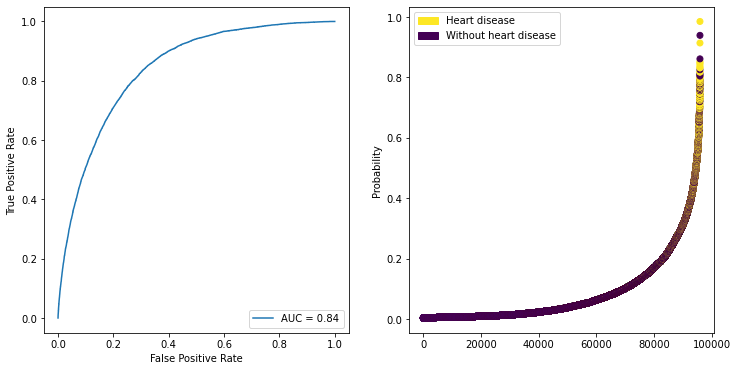

In [65]:
auc_score, target_thres, precision = evaluate(models['Ada'], X_test, y_test)
auc_scores['Ada'] = auc_score
precisions['Ada'] = precision

### Gradient Boosting

In [66]:
model = GradientBoostingClassifier(max_depth=5)
model.fit(X_train, y_train)
models['GDB'] = model

AUC score = 0.8525556453641845
Recall = 0.9
Precision = 0.17817940364783266
Recall = 0.95
Precision = 0.14854998238181474


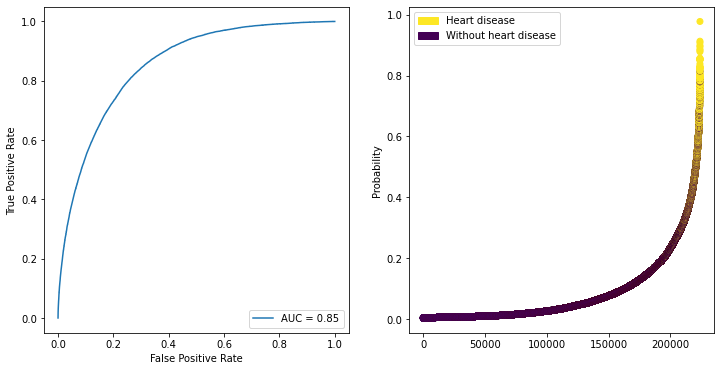

In [67]:
auc_score, target_thres, precision = evaluate(models['GDB'], X_train, y_train)

AUC score = 0.8404882832571263
Recall = 0.9
Precision = 0.176047197640118
Recall = 0.95
Precision = 0.1436519518423933


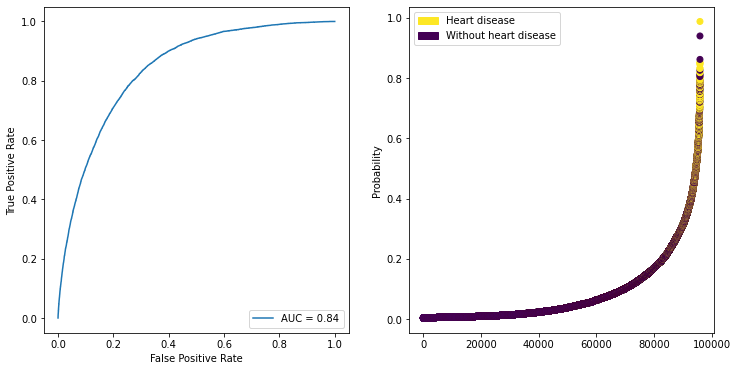

In [68]:
auc_score, target_thres, precision = evaluate(models['GDB'], X_test, y_test)
auc_scores['GDB'] = auc_score
precisions['GDB'] = precision

### Ensemble

In [69]:
models

{'LR': LogisticRegression(C=0.5, class_weight='balanced'),
 'SGD': SGDClassifier(loss='log'),
 'tree': DecisionTreeClassifier(class_weight='balanced', min_samples_leaf=600),
 'forest': RandomForestClassifier(min_samples_leaf=200),
 'Ada': GradientBoostingClassifier(max_depth=5),
 'GDB': GradientBoostingClassifier(max_depth=5),
 'NB': GaussianNB()}

In [120]:
estimators = {}
for model_name in models:
    if precisions[model_name][0.95] > 0.135:
        estimators[model_name] = models[model_name]

In [72]:
estimators = {}
for model_name in models:
    if precisions[model_name][0.95] > 0.135:
        estimators[model_name] = models[model_name]
model = VotingClassifier(estimators.items(),voting='soft')
model.fit(X_train, y_train)
models['ens'] = model

/home/dnj/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC score = 0.8497287892577576
Recall = 0.9
Precision = 0.17805747936797578
Recall = 0.95
Precision = 0.14808763703497965


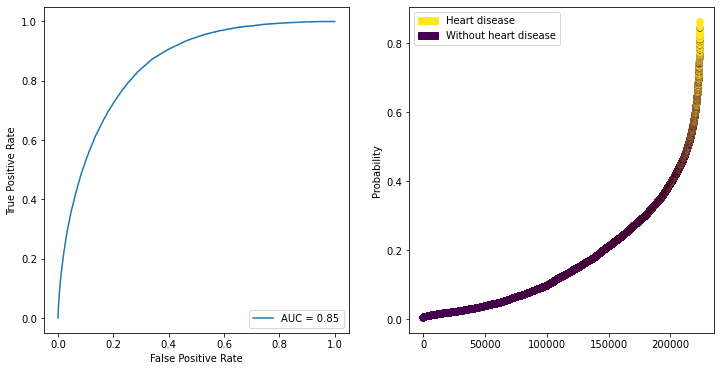

In [74]:
auc_score, target_thres, precision = evaluate(models['ens'], X_train, y_train)

AUC score = 0.8386766117696034
Recall = 0.9
Precision = 0.1730256291313928
Recall = 0.95
Precision = 0.14416212060191116


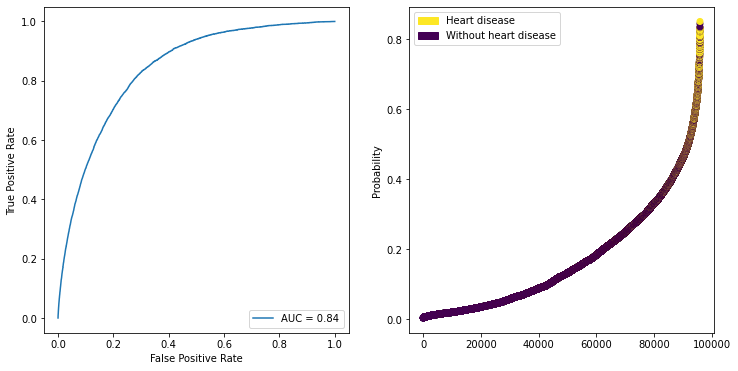

In [73]:
auc_score, target_thres, precision = evaluate(models['ens'], X_test, y_test)
auc_scores['ens'] = auc_score
precisions['ens'] = precision

### My ensemble model

In [108]:
np.array([])

array([], dtype=float64)

In [117]:
class my_ensemble():
    def __init__(self,estimators):
        self.estimators = estimators
    
    def predict_proba(self, X):
        pred_prob = np.zeros((X.shape[0], 2))
        for estimator_name, estimator in self.estimators.items():
            prob = estimator.predict_proba(X)
            pred_prob = pred_prob + prob
        pred_prob = pred_prob/len(self.estimators)
        return pred_prob
    

In [118]:
model = my_ensemble(estimators)
models['my_ens'] = model

AUC score = 0.8496316851721498
Recall = 0.9
Precision = 0.17776811684211616
Recall = 0.95
Precision = 0.14820386206445493


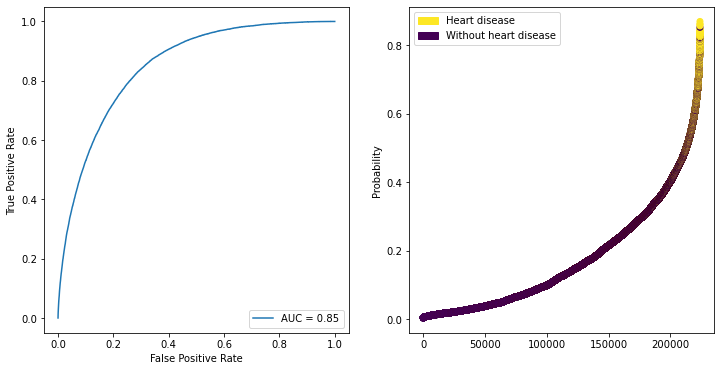

In [119]:
auc_score, target_thres, precision = evaluate(models['my_ens'], X_train, y_train)

AUC score = 0.8386808547598031
Recall = 0.9
Precision = 0.17311396282458869
Recall = 0.95
Precision = 0.14447155515602927


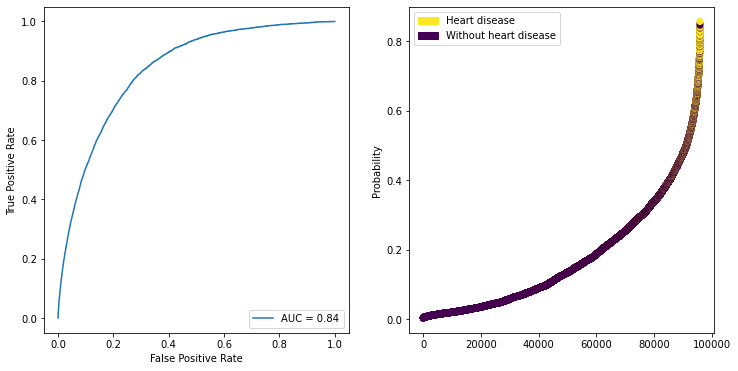

In [111]:
auc_score, target_thres, precision = evaluate(models['my_ens'], X_test, y_test)
auc_scores['my_ens'] = auc_score
precisions['my_ens'] = precision

In [115]:
pd.DataFrame(precisions).transpose()

,0.90,0.95
LR,0.170359,0.141629
SGD,0.169854,0.139958
tree,0.168041,0.138517
forest,0.173146,0.141289
Ada,0.176047,0.143655
GDB,0.176047,0.143652
NB,0.156808,0.129685
ens,0.173026,0.144162
my_ens,0.173114,0.144472


# Summary